In [18]:
import numpy as np
import pandas as pd
import scipy
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
import matplotlib
import tqdm
from tqdm import tqdm

# functions

In [20]:
def get_mean_dist(
    numsam,
    num_trials,
    dMeas,
    length,
    r1,
    r2,
    r3,
    la,
    lm
  ):

  allTrials=np.zeros((numsam,num_trials))
  Edist=np.zeros(num_trials)
  for j in range(num_trials):
    Isoslope=np.zeros(numsam)
    for n in range(numsam):
      if n  == 0:
        Isoslope[n]=2*np.abs(dMeas[n+1]-dMeas[n])/(length[n+1]+length[n])
      elif n == len(dMeas) -1:
        Isoslope[n]=2*np.abs(dMeas[n-1]-dMeas[n])/(length[n-1]+length[n])
      else:
        Isoslope[n]=np.abs(dMeas[n+1]-dMeas[n])/(length[n+1]+length[n])\
                    +np.abs(dMeas[n-1]-dMeas[n])/(length[n-1]+length[n])

    RElength=r2*np.random.randn(numsam)
    LengthError = Isoslope*RElength
    LEdMeas = LengthError + dMeas

    for n in range(numsam):
      if LEdMeas[n] < min(dMeas[max(0,n-1):min(numsam,n+1)]):
        LEdMeas[n]=min(dMeas[max(0,n-1):min(numsam,n+1)])
      elif LEdMeas[n] > max(dMeas[max(0,n-1):min(numsam,n+1)]):
        LEdMeas[n]=max(dMeas[max(0,n-1):min(numsam,n+1)])

    LengthError = LEdMeas - dMeas;

    totallength=np.cumsum(length)
    xx=np.asarray(range(max(totallength)+1))
    cs = CubicSpline(totallength, dMeas)
    dInterp=cs(xx)

    addbefore = dMeas[0]*np.ones(la);
    addafter = dMeas[-1]*np.ones(la);

    dInterpShift=np.concatenate((addbefore,dInterp.copy()))
    dInterp=np.concatenate((dInterp.copy(),addafter))
    Dd = dInterpShift-dInterp;
    Deltadelta = [Dd[l] for l in totallength]

    REdepth = (r3*np.random.randn(numsam))/la

    DepthError = Deltadelta*REdepth
    AnalysisError = r1*np.random.randn(numsam);
    SqSumError = (LengthError**2 + DepthError**2 + AnalysisError**2)**0.5;

    E = np.sum(SqSumError**2);
    Edist[j] = E;
    allTrials[:,j] = SqSumError;
    dMeasError = dMeas + SqSumError;
  return np.mean(Edist)

In [21]:
def get_df_from_plot_DPE_as_df(
    num_trials,
    numsam,
    length,
    dMeas,
    depth,
    openindx,
    r1,
    r2,
    r3,
    la,
    lm,
    finit,
    minratio,
    maxratio,
    stdev,
    mindepth,
    minlength,
    maxlength,
    mean_Edist,
    plot=False,
    verbose=True
  ):

  list_df=np.logspace(-4,1,50)
  DPE_error=np.zeros((num_trials,len(list_df)))
  for ind_try in tqdm(range(num_trials),disable=(not verbose)):
    avelength=np.mean(length)
    rlength = r2*np.random.randn(numsam)
    length2 = np.round(rlength).astype(int) + length #round to integers and add error
    #make sure that lengths are between min and max threshold specified previously
    length2=np.minimum(np.maximum(length2,minlength),maxlength)#ok

    rdepth=np.round(r3*np.random.randn(numsam)).astype(int)
    depth1 = np.round(rdepth).astype(int) + depth
    depth1=np.minimum(np.maximum(depth1,mindepth),la)

    #Determines the number of m's distal and proximal to those that directly correspond with d's
    #numbefore reflects the m's that are sampled into at the beginning of the profile because of sampling depth
    #numafter reflects the m's that contribute to the isotope values of the final samples in open-ended cases.

    #ceil rounds to nearest higher integer
    numbefore=int(np.ceil(la/avelength))
    numafter=int(np.ceil((lm-openindx)/avelength))+1

    lengthbefore=np.ones(numbefore)*avelength
    lengthafter=avelength*np.ones(numafter)

    #more definitions
    fmat = 1 - finit
    numcol=numbefore+numsam+numafter

    length2=np.concatenate((lengthbefore,length2,lengthafter,[lm]))
    depth1=np.concatenate((depth1,lengthbefore))

    B=np.zeros((int(length2[0]),numcol))
    B[:,0]=1
    for m in range(1,numcol):
        F=np.zeros((int(length2[m]),numcol))
        F[:,m]=1
        B=np.concatenate((B,F),axis=0)

    newnrow = sum(length2) - B.shape[0]
    addB = np.zeros((int(newnrow), numcol))
    B=np.concatenate((B,addB),axis=0)

    ncrow1 = (sum(length2)-openindx) # set non contributing rows
    ncrow2 = sum(length2)

    B[int(ncrow1):int(ncrow2),:] = 0 # fill noncontributing rows with 0

    #remove last column
    B=B[:,:-1]

    o = 0;
    AB = finit*(np.mean(B[o:o+lm-1,:],0)) + fmat*np.mean(B[o:o+lm-1,:],0);
    AB = AB/(np.sum(B[o,:]))
    AB=AB.reshape(AB.size,1);

    for o in range(int(np.sum(length2))-lm):
      p = finit*(B[o,:]) + fmat*(np.mean(B[o:(o+lm-1),:],0));
      if sum(p)!=0:
        p = p/sum(p)
      AB = np.concatenate((AB,p.reshape(p.size,1)),axis=1)
    AB=AB[:,1:].T

    clength=np.cumsum(length2).astype(int)

    A = AB[0:1,:];
    for k in range(numbefore,numsam+numbefore):
      E = AB[0,:]
      E=E.reshape(1,-1);
      for j in range(int(depth1[k - numbefore])):
        e = np.mean(AB[(clength[k-1] - j+1)-1:(clength[k] - j)-1,:],0)
        E = np.concatenate((E, e.reshape(1,-1)),axis=0)
      E = E[1:,:]

      meanE = np.mean(E,axis=0).reshape(1,-1)
      A = np.concatenate((A, meanE),axis=0)
    A = A[1:,:]

    I = np.eye(numsam)
    dMeasr = dMeas + r1 * np.random.randn(numsam)
    NoB = numbefore
    NoA = numafter - 1

    mm = np.zeros(numsam+numbefore+numafter-1)+minratio;
    for x in range(1,numsam+numbefore+numafter-1):
      mm[x] = mm[x-1]+stdev*np.random.randn();
      while mm[x]>maxratio or mm[x]<minratio:
        mm[x] = mm[x-1]+stdev*np.random.randn();

    ind_df=-1
    for df in list_df:
      ind_df+=1
      mEst= mm + np.matmul(np.matmul(A.T,np.linalg.inv(np.matmul(A,A.T)+ df*I)), dMeasr-np.matmul(A,mm))
      dPred = np.matmul(A,mEst)
      dPe=dPred-dMeas
      DPE=np.sum(dPe**2)
      DPE_error[ind_try,ind_df]=DPE

  if plot:
    plt.plot(list_df,np.mean(DPE_error,0),label='DPE')
    plt.plot(list_df,np.ones(len(list_df))*mean_Edist,'k--',label='mean Edist')
    plt.xscale('log')
    plt.xlabel('df')
    plt.legend();

  interpolated = CubicSpline(list_df, np.mean(DPE_error,0)-mean_Edist)
  roots=interpolated.roots()
  df=max(roots[roots>0])

  return df

In [22]:
def get_inverse_pred(
    num_trials,
    numsam,
    length,
    dMeas,
    depth,
    openindx,
    r1,
    r2,
    r3,
    la,
    lm,
    finit,
    minratio,
    maxratio,
    stdev,
    mindepth,
    minlength,
    maxlength,
    df,
    verbose=True):


  dPred_mat=np.zeros((num_trials,numsam))
  mEst_mat=np.zeros((num_trials,numsam))
  for ind_try in tqdm(range(num_trials),disable=(not verbose)):
    avelength=np.mean(length)
    rlength = r2*np.random.randn(numsam)
    length2 = np.round(rlength).astype(int) + length #round to integers and add error
    #make sure that lengths are between min and max threshold specified previously
    length2=np.minimum(np.maximum(length2,minlength),maxlength)#ok

    rdepth=np.round(r3*np.random.randn(numsam)).astype(int)
    depth1 = np.round(rdepth).astype(int) + depth
    depth1=np.minimum(np.maximum(depth1,mindepth),la)

    #Determines the number of m's distal and proximal to those that directly correspond with d's
    #numbefore reflects the m's that are sampled into at the beginning of the profile because of sampling depth
    #numafter reflects the m's that contribute to the isotope values of the final samples in open-ended cases.

    #ceil rounds to nearest higher integer
    numbefore=int(np.ceil(la/avelength))
    numafter=int(np.ceil((lm-openindx)/avelength))+1

    lengthbefore=np.ones(numbefore)*avelength
    lengthafter=avelength*np.ones(numafter)

    #more definitions
    fmat = 1 - finit
    numcol=numbefore+numsam+numafter

    length2=np.concatenate((lengthbefore,length2,lengthafter,[lm]))
    depth1=np.concatenate((depth1,lengthbefore))

    B=np.zeros((int(length2[0]),numcol))
    B[:,0]=1
    for m in range(1,numcol):
        F=np.zeros((int(length2[m]),numcol))
        F[:,m]=1
        B=np.concatenate((B,F),axis=0)

    newnrow = sum(length2) - B.shape[0]
    addB = np.zeros((int(newnrow), numcol))
    B=np.concatenate((B,addB),axis=0)

    ncrow1 = (sum(length2)-openindx) # set non contributing rows
    ncrow2 = sum(length2)

    B[int(ncrow1):int(ncrow2),:] = 0 # fill noncontributing rows with 0

    #remove last column
    B=B[:,:-1]

    o = 0;
    AB = finit*(np.mean(B[o:o+lm-1,:],0)) + fmat*np.mean(B[o:o+lm-1,:],0);
    AB = AB/(np.sum(B[o,:]))
    AB=AB.reshape(AB.size,1);

    for o in range(int(np.sum(length2))-lm):
      p = finit*(B[o,:]) + fmat*(np.mean(B[o:(o+lm-1),:],0));
      if sum(p)!=0:
        p = p/sum(p)
      AB = np.concatenate((AB,p.reshape(p.size,1)),axis=1)
    AB=AB[:,1:].T

    clength=np.cumsum(length2).astype(int)

    A = AB[0:1,:];
    for k in range(numbefore,numsam+numbefore):
      E = AB[0,:]
      E=E.reshape(1,-1);
      for j in range(int(depth1[k - numbefore])):
        e = np.mean(AB[(clength[k-1] - j+1)-1:(clength[k] - j)-1,:],0)
        E = np.concatenate((E, e.reshape(1,-1)),axis=0)
      E = E[1:,:]

      meanE = np.mean(E,axis=0).reshape(1,-1)
      A = np.concatenate((A, meanE),axis=0)
    A = A[1:,:]

    I = np.eye(numsam)
    dMeasr = dMeas + r1 * np.random.randn(numsam)
    NoB = numbefore
    NoA = numafter - 1

    mm = np.zeros(numsam+numbefore+numafter-1)+minratio;
    for x in range(1,numsam+numbefore+numafter-1):
      mm[x] = mm[x-1]+stdev*np.random.randn();
      while mm[x]>maxratio or mm[x]<minratio:
        mm[x] = mm[x-1]+stdev*np.random.randn();


    mEst=mm + np.matmul(np.matmul(A.T,np.linalg.inv(np.matmul(A,A.T)+ df*I)), dMeasr-np.matmul(A,mm))
    mEst_mat[ind_try,:]=mEst[numbefore:numsam+numbefore]
    dPred_mat[ind_try,:]=np.matmul(A,mEst)
  return mEst_mat

In [27]:
def get_inv_passey_inv_model(
    dMeas,
    length,
    depth,
    num_trials=100,
    r1=0.3,
    r2=1,
    r3=2,
    la=15,
    lm=250,
    minlength=3,
    maxlength=40,
    mindepth=5,
    openindx=1,
    finit=0.25,
    verbose=True
):
  '''
  This function applies the inverse model of Passey et. al
  (Passey, B. H., Cerling, T. E., Schuster, G. T., Robinson, T. F., Roeder, B. L., & Krueger, S. K. (2005).
  Inverse methods for estimating primary input signals from time-averaged isotope profiles.
  Geochimica et Cosmochimica Acta, 69(16), 4101-4116.) to the input signal where:
    -dMeas is the list of temperature estimated (or the list of observed istope concentration sicne both are linearly related) at each measure
    -length the the height at which teeth measures where done
    -depth is the depth of the measure
    -num_trials is the number of trials
    -other parameters are explained in the papers and are not to be changed
  It returns a matrix of size the number of samples x the number of trials. Each trial corresponds to a possible inversion as explained in Passey's.
  '''
  numsam=len(dMeas)
  lamm=la/10
  minratio=np.quantile(dMeas,0.1)
  maxratio=np.quantile(dMeas,0.9)
  fmat=1-finit
  stdev=maxratio-minratio

  params_Edist={"numsam":numsam,
                "num_trials":num_trials,
                "dMeas":dMeas,
                "length":length,
                "r1":r1,
                "r2":r2,
                "r3":r3,
                "la":la,
                "lm":lm}
  if verbose:
    print('Computing mean distance...')
  mean_Edist=get_mean_dist(**params_Edist)

  params_get_df={"num_trials":num_trials,
                "numsam":numsam,
                "length":length,
                "dMeas":dMeas,
                "openindx":openindx,
                "mindepth":mindepth,
                "r1":r1,
                "r2":r2,
                "r3":r3,
                "la":la,
                "lm":lm,
                "depth":depth,
                "finit":finit,
                "minratio":minratio,
                "maxratio":maxratio,
                "minlength":minlength,
                "maxlength":maxlength,
                "stdev":stdev,
                "verbose":verbose,
                "mean_Edist":mean_Edist}
  if verbose:
    print('Computing DPE...')
  df=get_df_from_plot_DPE_as_df(**params_get_df)

  params_get_pred={"num_trials":num_trials,
                "numsam":numsam,
                "length":length,
                "dMeas":dMeas,
                "openindx":openindx,
                "mindepth":mindepth,
                "r1":r1,
                "r2":r2,
                "r3":r3,
                "la":la,
                "lm":lm,
                "depth":depth,
                "finit":finit,
                "minratio":minratio,
                "maxratio":maxratio,
                "minlength":minlength,
                "maxlength":maxlength,
                "stdev":stdev,
                "verbose":verbose,
                "df":df}
  if verbose:
    print('Computing inverse model...')
  mEst_mat=get_inverse_pred(**params_get_pred)
  return mEst_mat

In [7]:
def custom_sinus(x, A, k, phi, T):
    return -A/2 * np.sin((2 * np.pi / T) * x - phi) + k

def error_func_shift(param, data_points):
    # This function returns the error mentioned above using the parameters and the data points x and y
    x, y = data_points
    A, k, T, phi = param
    error = 0
    for i in range(len(x)):
        error += (-A/2 * np.sin(2 * np.pi / T * x[i] - phi) + k - y[i])**2
    return error

def get_sinus_fit(x, y):
    # Given the points xm2, xm3, ym2, ym3, this function finds the parameters A, k, T, shift, and phi
    # that minimize the error defined above.

    data_points = [x, y]

    A0 = (max(y) - min(y))
    k0 = np.mean(y)
    T0 = max(x) - min(x)
    phi0 = ((np.pi * (2 / T0 * x[np.argmin(y)] - 1/2)) % (2 * np.pi) +
            (np.pi * (2 / T0 * x[np.argmax(y)] - 3/2)) % (2 * np.pi)) / 2
    param0 = np.asarray([A0, k0, T0, phi0])

    A_min = 0.8 * A0
    A_max = 1.2 * A0
    k_min = k0 - 0.2 * abs(k0)
    k_max = k0 + 0.2 * abs(k0)
    T_min = 0.5 * T0
    T_max = 1.2 * T0

    bounds = ((A_min, A_max), (k_min, k_max), (T_min, T_max), (-np.inf, np.inf))

    res_optim = scipy.optimize.minimize(error_func_shift, param0, args=data_points, bounds=bounds)

    A, k, T, phi = res_optim.x

    res = {"A": A, "k": k, "T": T, "phi": phi}

    return res


# load data

In [8]:
data=pd.read_csv('/content/drive/MyDrive/Autre/Archeo/Data/equus_alldata.csv',delimiter=';')
data=data[[c for c in data.columns if c[:2]!='Un']].dropna()
for c in data.columns:
  try:
    data[c]=data[c].str.replace(',','.').astype(float)
  except:
    pass
data[['horse','index_tooth']]=data.nom_sample.str.split(' ',expand=True)
data['index_tooth']=data['index_tooth'].str.replace('bis','').astype(int)
data.sample(5)

,nom_sample,dent,hauteur_sample,d13CVPDB_COR,d13C/12C_SD,d18OVPD_COR,d18O/16O _SD,d18Ovsmow,predicted_phosphate_Iacumin1996,horse,index_tooth
184,Fritsch_LR2_c4_eq 3,nd,82.30,-11.025100,0.016,-6.413700,0.011,24.298053,15.312091,Fritsch_LR2_c4_eq,3
292,PIV20_Eq_L111 2,nd,57.12,-11.358300,0.012,-6.559100,0.029,24.148158,15.165195,PIV20_Eq_L111,2
57,R_5378_P3/4 5,P3/4,47.28,-11.068286,0.021,-4.107286,0.032,26.675758,17.642243,R_5378_P3/4,5
249,Fritsch_LR6_c4_eq 12,M1/2,16.03,-11.063875,0.013,-4.804750,0.016,25.956735,16.937600,Fritsch_LR6_c4_eq,12
272,Fritsch_LR8_equus 6,nd,49.00,-10.356833,0.016,-5.322500,0.031,25.422982,16.414522,Fritsch_LR8_equus,6


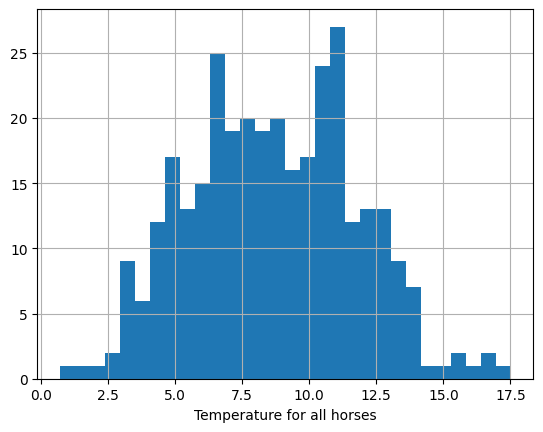

In [9]:
list_horses=data.horse.unique()
data['d18Ovsmow']=(data['d18OVPD_COR']*1.03091+30.91)
data['O18phosphate']=data['d18Ovsmow']*0.98-8.5
data['enamel']=data['O18phosphate']
data['d18Oprecipitation']=data['enamel']*1.4-31.72
data['temperature']=(data['d18Oprecipitation']+13.74)/0.53
data["temperature"].hist(bins=30);
plt.xlabel('Temperature for all horses');

# results

## Single horse

In [97]:
horse=list_horses[3]

horse_df=data.loc[data.horse==horse].sort_values(by='index_tooth').copy()
horse_df['depth']=10.5
horse_df['length']=horse_df['hauteur_sample'].diff(-1)*10
horse_df=horse_df.dropna()
horse_df.head(5)

,nom_sample,dent,hauteur_sample,d13CVPDB_COR,d13C/12C_SD,d18OVPD_COR,d18O/16O _SD,d18Ovsmow,predicted_phosphate_Iacumin1996,horse,index_tooth,O18phosphate,enamel,d18Oprecipitation,temperature,depth,length
53,R_5378_P3/4 1,P3/4,61.40,-10.480286,0.018,-5.726286,0.027,25.006715,16.006580,R_5378_P3/4,1,16.006580,16.006580,-9.310787,8.357005,10.5,31.6
54,R_5378_P3/4 2,P3/4,58.24,-10.717286,0.018,-5.050286,0.023,25.703610,16.689538,R_5378_P3/4,2,16.689538,16.689538,-8.354647,10.161043,10.5,36.7
55,R_5378_P3/4 3,P3/4,54.57,-10.807286,0.010,-5.079286,0.018,25.673714,16.660239,R_5378_P3/4,3,16.660239,16.660239,-8.395665,10.083651,10.5,33.9
56,R_5378_P3/4 4,P3/4,51.18,-10.938286,0.016,-4.613286,0.014,26.154118,17.131035,R_5378_P3/4,4,17.131035,17.131035,-7.736551,11.327263,10.5,39.0
57,R_5378_P3/4 5,P3/4,47.28,-11.068286,0.021,-4.107286,0.032,26.675758,17.642243,R_5378_P3/4,5,17.642243,17.642243,-7.020860,12.677623,10.5,35.5


In [98]:
dMeas=horse_df['temperature'].astype(float).tolist()
length=horse_df['length'].astype(int).tolist()
depth=horse_df['depth'].astype(int).tolist()

mEst_mat=get_inv_passey_inv_model(dMeas=dMeas,length=length,depth=depth,verbose=True)

Computing mean distance...
Computing DPE...


100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


Computing inverse model...


100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


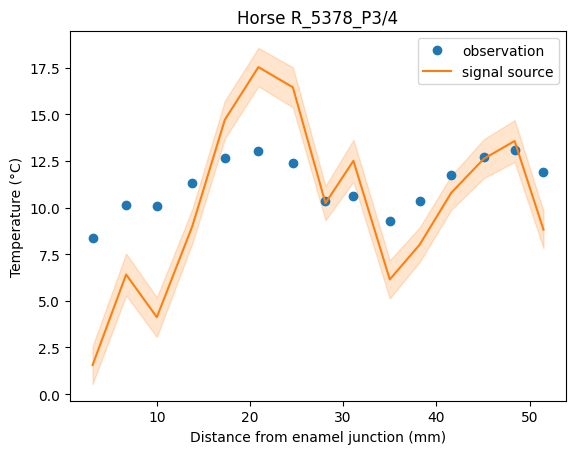

In [99]:
x=np.cumsum(length)/10
y=np.mean(mEst_mat,0)
y_std=np.std(mEst_mat,0)
plt.plot(x,dMeas,'o',label='observation')
p=plt.plot(x,y,label='signal source');
plt.fill_between(x,y-y_std,y+y_std,
                 color=p[0].get_color(),
                 alpha=0.2)
plt.legend();
plt.title(f'Horse {horse}')
plt.ylabel('Temperature (°C)')
plt.xlabel('Distance from enamel junction (mm)');

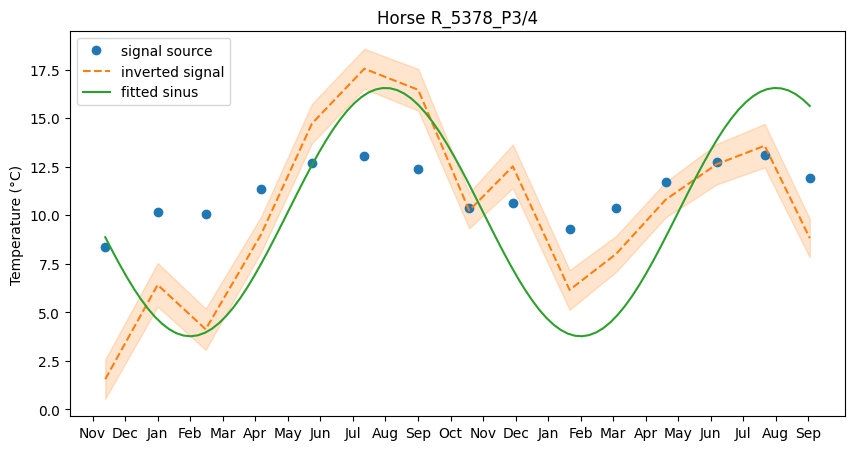

In [100]:
# Get sinusoidal fit parameters using the function get_sinus_fit with input data x and y
param = get_sinus_fit(x, y)
A = param["A"]  # Amplitude of the sinusoidal curve
k = param["k"]  # Wave number
T = param["T"]  # Period of the sinusoidal curve
phi = param["phi"]  # Phase shift

# Generate sinusoidal curve using the obtained parameters A, k, phi, and T
y_sin = custom_sinus(x, A=A, k=k, phi=phi, T=T)

# Change the x-axis to scale it over 2 years
# Divide x by T and multiply by 12 to make one period (distance between 2 maxima) equal to 12
# Adjust the minimum x_month[np.argmin(y_sin)] to be at the 13th point
x_month = x * 12 / T
x_month_shifted = x_month + 13 - x_month[np.argmin(y_sin)]
min_month = int(min(x_month_shifted))
max_month = int(max(x_month_shifted))

# Plot the results
plt.figure(figsize=(10, 5))
y_std = np.std(mEst_mat, 0)
plt.plot(x_month_shifted, dMeas, 'o',label='signal source')
p=plt.plot(x_month_shifted, y,'--', label='inverted signal' )
plt.fill_between(x_month_shifted, y - y_std, y + y_std,color=p[0].get_color(),alpha=0.2)
x_sin=np.linspace(min(x_month_shifted),max(x_month_shifted),100)
y_sin = custom_sinus(x_sin, A=A, k=k, phi=-1/12*2*np.pi, T=12)
plt.plot(x_sin, y_sin, label='fitted sinus')


months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 3
months = months[min_month-1:max_month]
plt.xticks(np.arange(min_month, max_month+1), months)
plt.ylabel('Temperature (°C)')
plt.title(f'Horse {horse}')
plt.legend();


## All horses

100%|██████████| 19/19 [05:48<00:00, 18.32s/it]


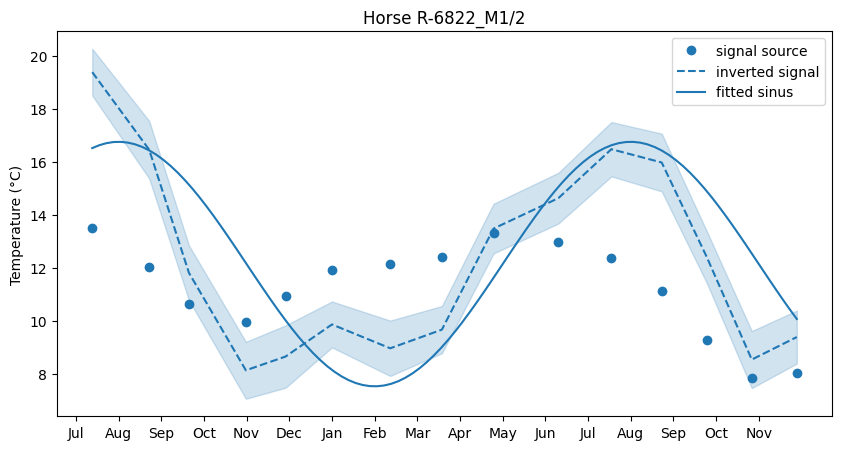

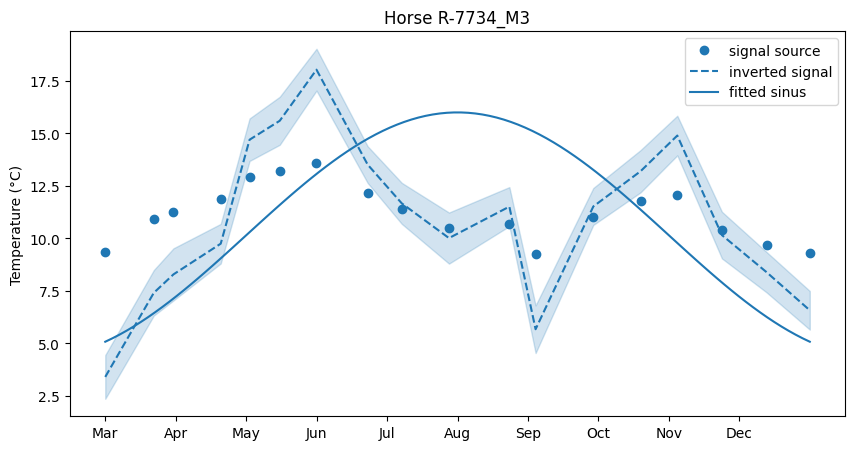

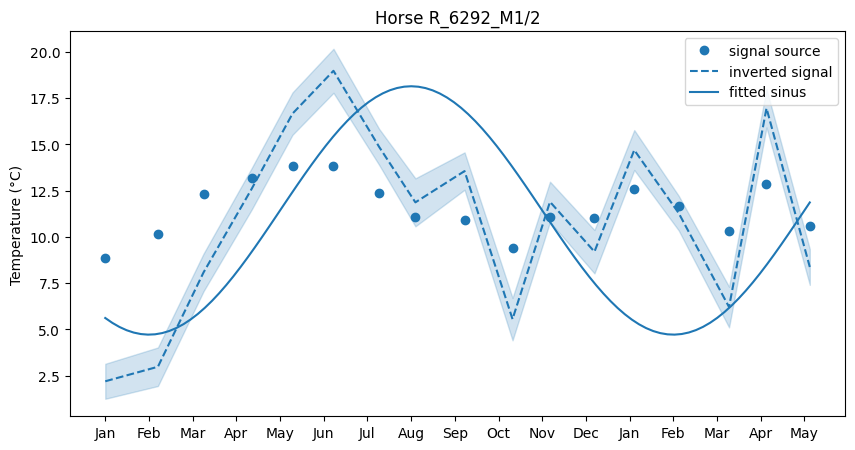

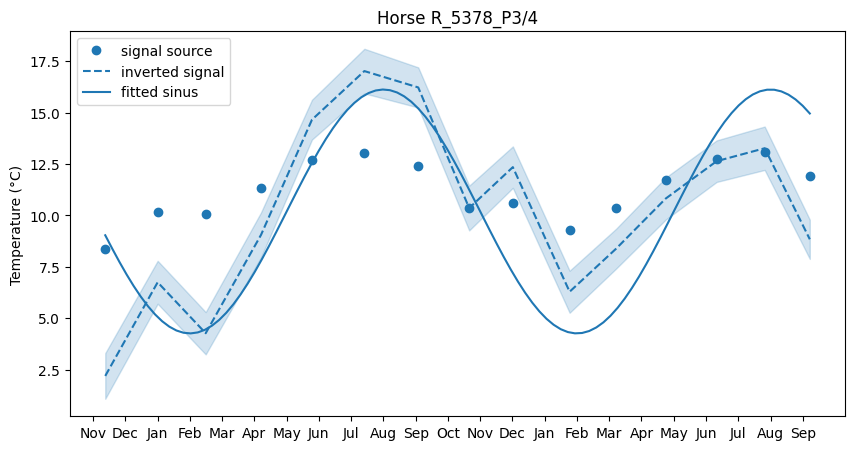

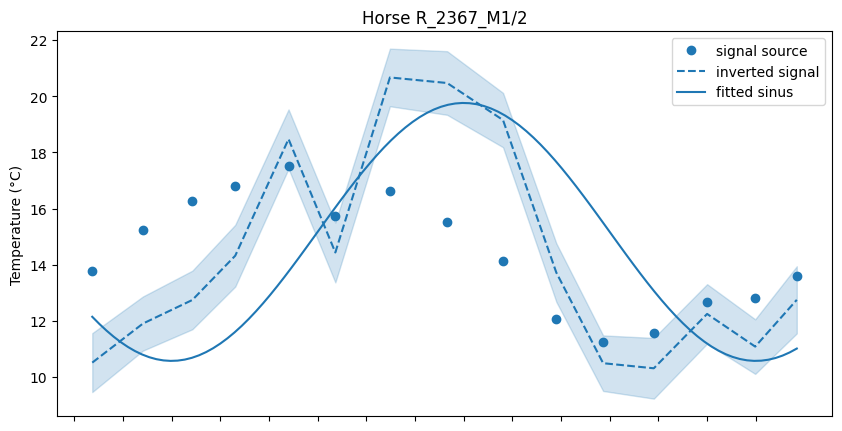

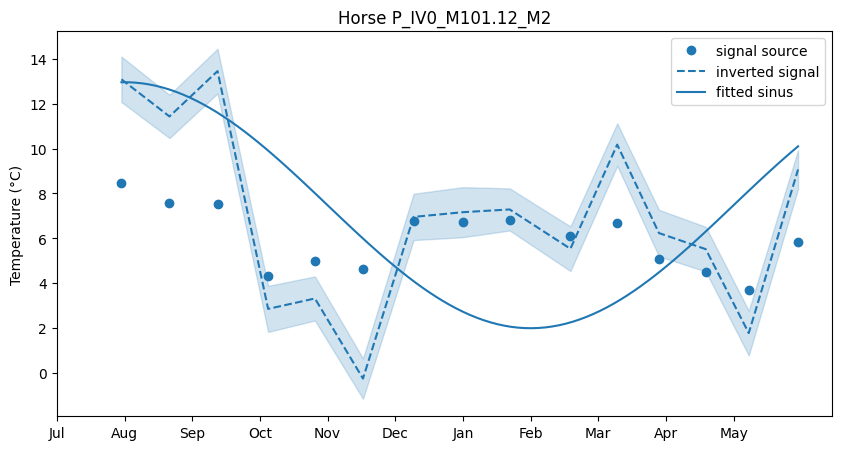

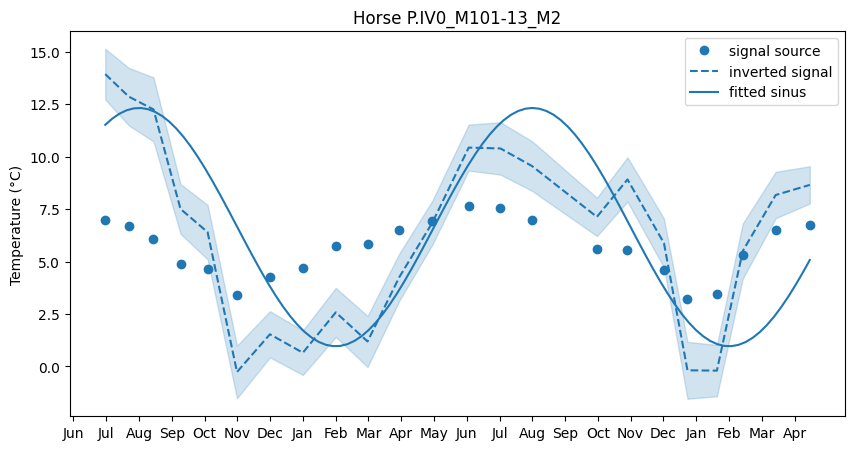

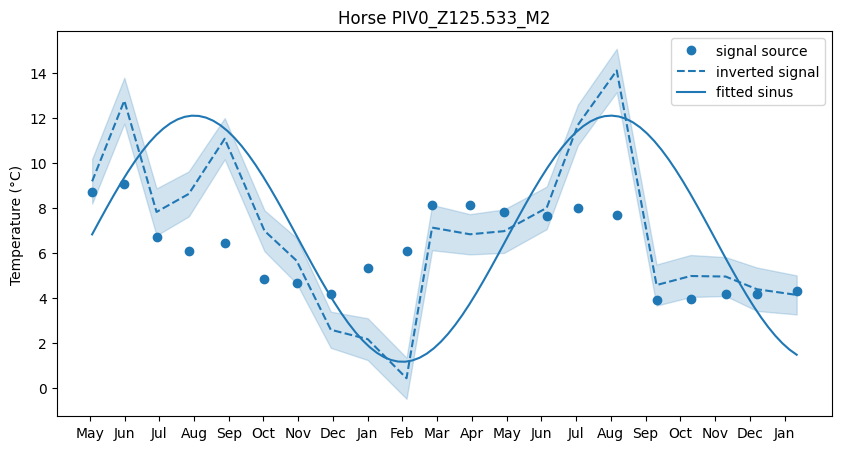

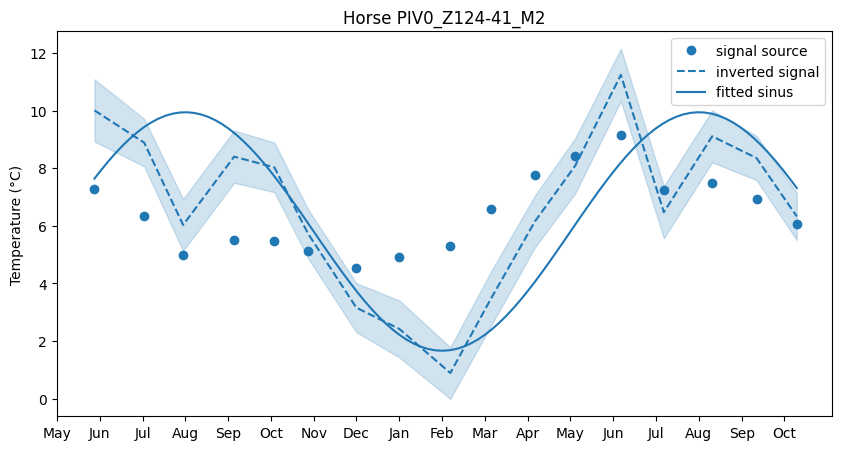

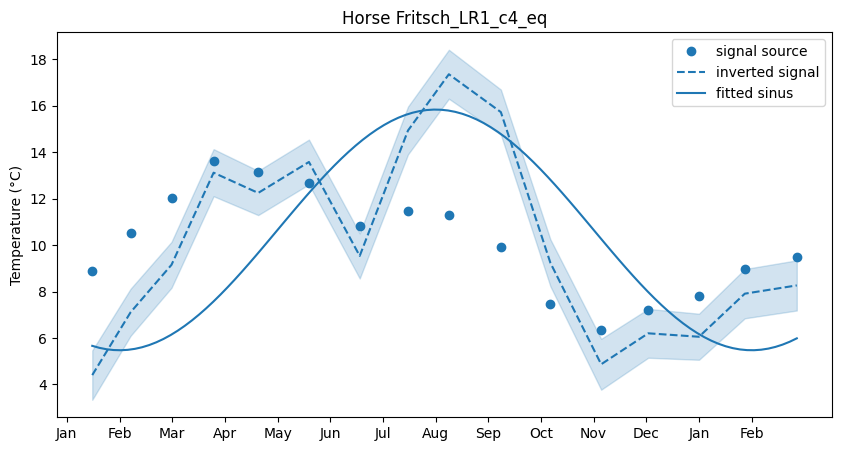

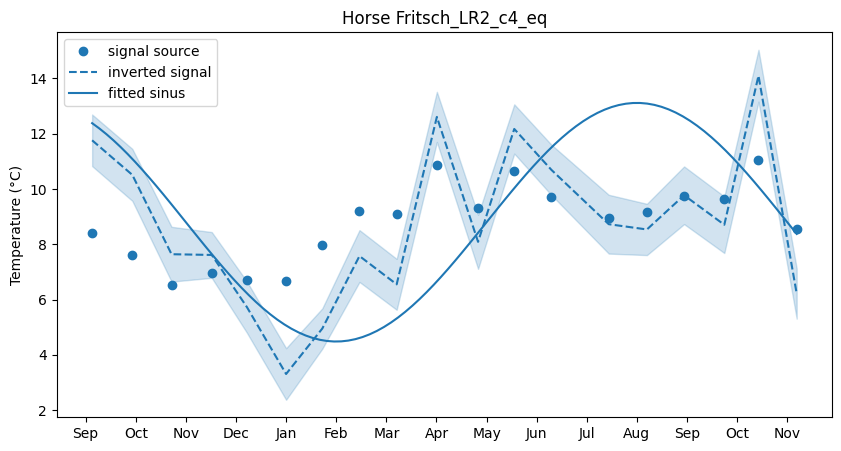

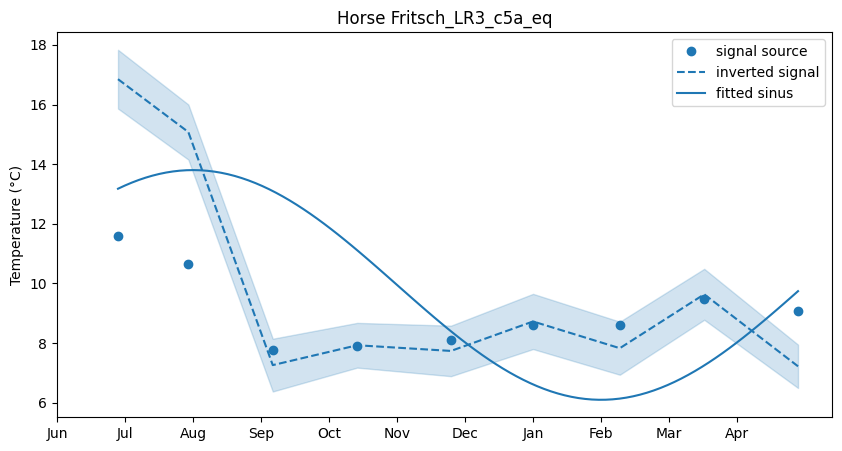

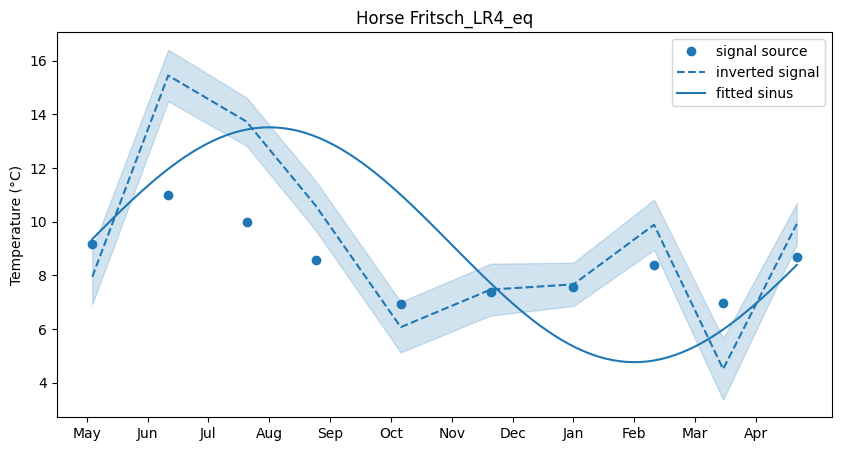

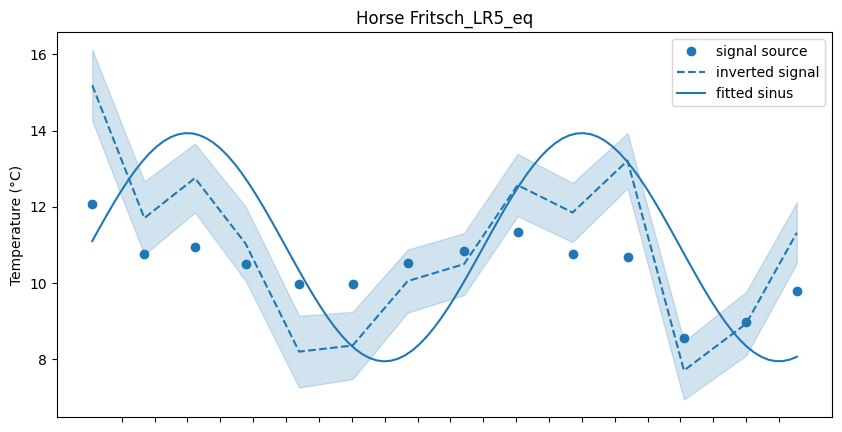

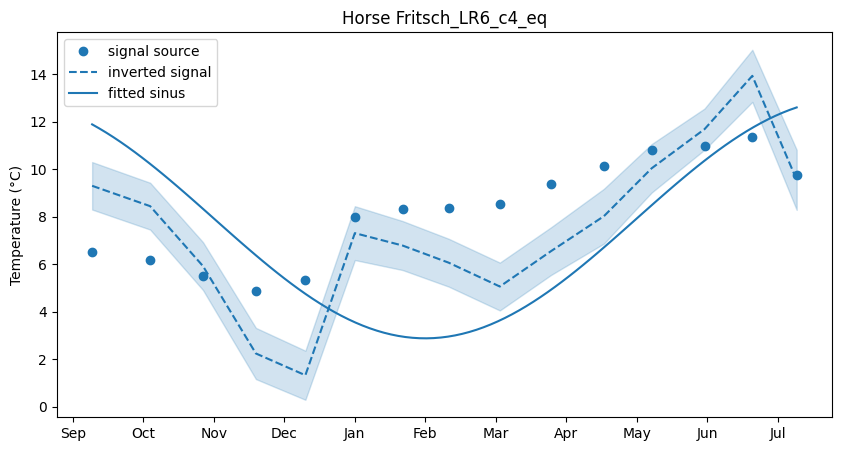

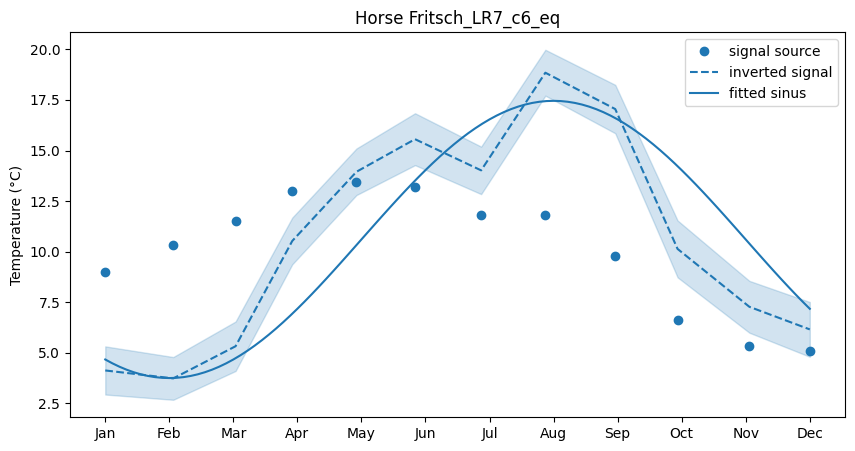

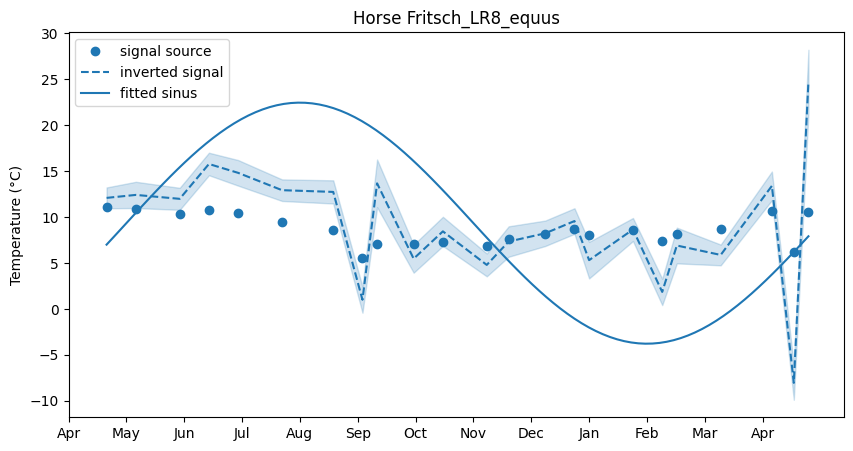

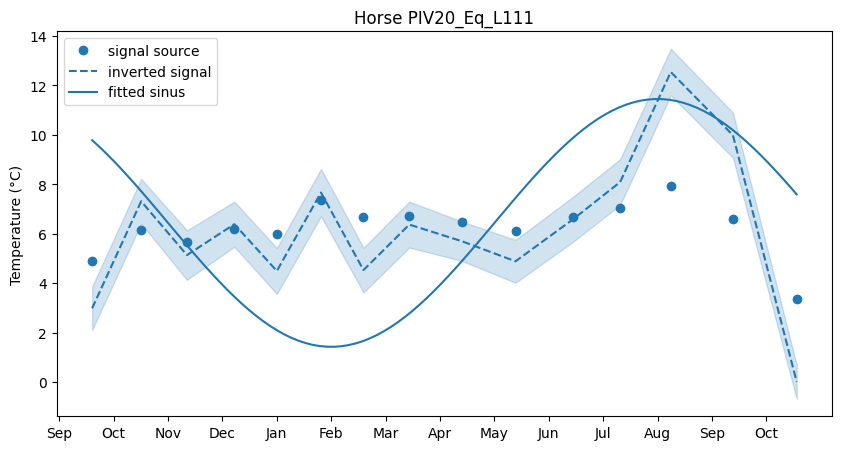

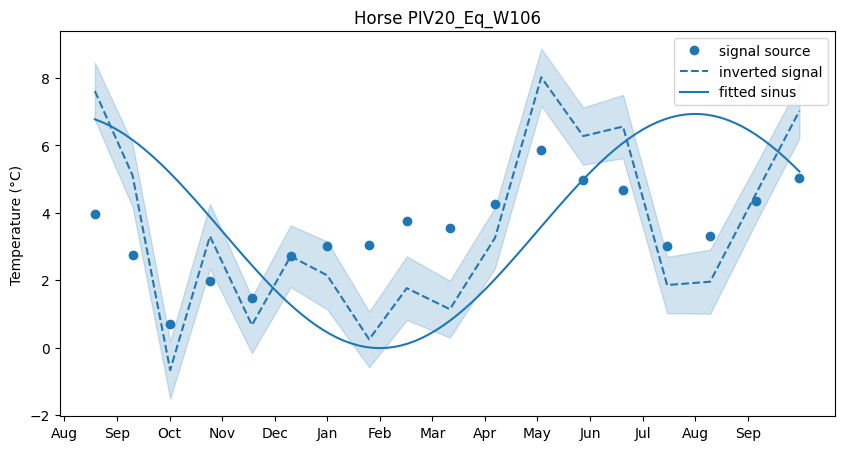

In [101]:
for horse in tqdm(list_horses):

  horse_df=data.loc[data.horse==horse].sort_values(by='index_tooth').copy()
  horse_df['depth']=10.5
  horse_df['length']=horse_df['hauteur_sample'].diff(-1)*10
  horse_df=horse_df.dropna()

  dMeas=horse_df['temperature'].astype(float).tolist()
  length=horse_df['length'].astype(int).tolist()
  depth=horse_df['depth'].astype(int).tolist()

  mEst_mat=get_inv_passey_inv_model(dMeas=dMeas,length=length,depth=depth,verbose=False)
  x=np.cumsum(length)/10
  y=np.mean(mEst_mat,0)
  y_std=np.std(mEst_mat,0)

  # Get sinusoidal fit parameters using the function get_sinus_fit with input data x and y
  param = get_sinus_fit(x, y)
  A = param["A"]  # Amplitude of the sinusoidal curve
  k = param["k"]  # Wave number
  T = param["T"]  # Period of the sinusoidal curve
  phi = param["phi"]  # Phase shift

  # Change the x-axis to scale it over 2 years
  # Divide x by T and multiply by 12 to make one period (distance between 2 maxima) equal to 12
  # Adjust the minimum x_month[np.argmin(y_sin)] to be at the 13th point
  y_sin = custom_sinus(x, A=A, k=k, phi=phi, T=T)
  x_month = x * 12 / T
  x_month_shifted = x_month + 13 - x_month[np.argmin(y_sin)]
  min_month = int(min(x_month_shifted))
  max_month = int(max(x_month_shifted))

  #sinusoid
  x_sin=np.linspace(min(x_month_shifted),max(x_month_shifted),100)
  y_sin = custom_sinus(x_sin, A=A, k=k, phi=-1/12*2*np.pi, T=12)

  # Plot the results
  plt.figure(figsize=(10, 5))
  p=plt.plot(x_month_shifted, dMeas, 'o',label='signal source')
  plt.plot(x_month_shifted, y,'--',color=p[0].get_color(), label='inverted signal' )
  plt.fill_between(x_month_shifted, y - y_std, y + y_std,color=p[0].get_color(),alpha=0.2)
  plt.plot(x_sin, y_sin,color=p[0].get_color(), label='fitted sinus')


  months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 3
  months = months[min_month-1:max_month]
  plt.xticks(np.arange(min_month, max_month+1), months)
  plt.ylabel('Temperature (°C)')
  plt.title(f'Horse {horse}')
  plt.legend();


  horse=horse.replace('/','-')
  plt.savefig(f'/content/drive/MyDrive/Autre/Archeo/Data/Temperature_horse_{horse}.pdf')